In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import sys
import time

In [2]:
# import pytorch modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [3]:
# plotting
sys.path.insert(0,'..')
from utilz import plot_stroke

In [4]:
# find gpu
cuda = torch.cuda.is_available()

In [5]:
# hyperparamters
timesteps = 300
num_clusters = 20
cell_size = 300
nlayers = 2
bsize = 100
init_lr = 1E-3

In [6]:
# prepare training data
train_data = np.load('train_data_2.npy')
train_data = torch.from_numpy(train_data)
if cuda:
    train_data = train_data.cuda()
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=bsize, shuffle=True)
    
# prepare validation data
validation_data = np.load('validation_data_2.npy')
validation_data = torch.from_numpy(validation_data)
if cuda:
    validation_data = validation_data.cuda()
validation_loader = torch.utils.data.DataLoader(
    validation_data, batch_size=bsize, shuffle=True)

In [7]:
# 2-layer lstm with mixture of gaussian parameters as outputs
# skip connections added
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = 3, hidden_size = cell_size, num_layers = 1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size = cell_size+3, hidden_size = cell_size, num_layers = 1, batch_first=True)
        self.linear1 = nn.Linear(cell_size*2, 1+ num_clusters*6)
        self.tanh = nn.Tanh()
        
    def forward(self, x, prev, prev2):
        timesteps = x.shape[1]
        h1, (h1_n, c1_n) = self.lstm(x, prev)
        x2 = torch.cat([h1, x], dim=-1)
        h2, (h2_n, c2_n) = self.lstm2(x2, prev2)
        h = torch.cat([h1, h2], dim=-1)
        params = self.linear1(h)
        weights = F.softmax(params.narrow(-1, 0, num_clusters), dim=-1)
        mu_1 = params.narrow(-1, num_clusters, num_clusters)
        mu_2 = params.narrow(-1, 2*num_clusters, num_clusters)
        log_sigma_1 = params.narrow(-1, 3*num_clusters, num_clusters)
        log_sigma_2 = params.narrow(-1, 4*num_clusters, num_clusters)
        p = self.tanh(params.narrow(-1, 5*num_clusters, num_clusters))
        end = F.sigmoid(params.narrow(-1, 6*num_clusters, 1))
        
        return end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, (h1_n, c1_n), (h2_n, c2_n)

In [8]:
# training objective
def log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, x):
    timesteps = x.shape[1]
    x_0 = x.narrow(-1,0,1)
    x_1 = x.narrow(-1,1,1)
    x_2 = x.narrow(-1,2,1)
    end_loglik = (x_0*end + (1-x_0)*(1-end)).log()
    const = 1E-20
    pi_term = torch.Tensor([2*np.pi])
    if cuda:
        pi_term = pi_term.cuda()
    pi_term = -Variable(pi_term, requires_grad = False).log()
    z = (x_1 - mu_1)**2/(log_sigma_1.exp()**2)\
        + ((x_2 - mu_2)**2/(log_sigma_2.exp()**2)) \
        - 2*p*(x_1-mu_1)*(x_2-mu_2)/((log_sigma_1 + log_sigma_2).exp())
    mog_lik1 =  pi_term -log_sigma_1 - log_sigma_2 - 0.5*((1-p**2).log())
    mog_lik2 = z/(2*(1-p**2))
    mog_lik = (weights.log() + (mog_lik1 - mog_lik2)).exp().sum(dim=-1)
    return end_loglik.sum() + (mog_lik+const).log().sum()

In [9]:
def decay_learning_rate(optimizer, decay = 1.01):
    state_dict = optimizer.state_dict()
    lr = state_dict['param_groups'][0]['lr']
    lr /= decay
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)
    return optimizer

In [10]:
def save_checkpoint(epoch, model, validation_loss, optimizer, filename='best.pt'):
    checkpoint=({'epoch': epoch+1,
    'model': model.state_dict(),
    'validation_loss': validation_loss,
    'optimizer' : optimizer.state_dict()
    })
    torch.save(checkpoint, filename)

In [11]:
model = LSTM()
if cuda:
    model = model.cuda()

In [18]:
epochs = 10
optimizer = optim.Adam([
                {'params':model.parameters()},
            ], lr=init_lr)

In [54]:
# training
h1_init, c1_init = torch.zeros((1,bsize,cell_size)), torch.zeros((1,bsize,cell_size))
zero_tensor = torch.zeros((bsize, 1, 3))
h2_init, c2_init = torch.zeros((1,bsize,cell_size)), torch.zeros((1,bsize,cell_size))

h1_init2, c1_init2 = torch.zeros((1, bsize,cell_size)),\
                    torch.zeros((1,bsize,cell_size))
h2_init2, c2_init2 = torch.zeros((1, bsize,cell_size)),\
                    torch.zeros((1,bsize,cell_size))
zero_tensor2 = torch.zeros((bsize, 1, 3))
if cuda:
    h1_init = h1_init.cuda()
    c1_init = c1_init.cuda()
    h2_init = h2_init.cuda()
    c2_init = c2_init.cuda()
    zero_tensor = zero_tensor.cuda()
    h1_init2 = h1_init2.cuda()
    c1_init2 = c1_init2.cuda()
    h2_init2 = h2_init2.cuda()
    c2_init2 = c2_init2.cuda()
    zero_tensor2 = zero_tensor2.cuda()
h1_init, c1_init = Variable(h1_init), Variable(c1_init)
h2_init, c2_init = Variable(h2_init), Variable(c2_init)
h1_init2, c1_init2 = Variable(h1_init2), Variable(c1_init2)
h2_init2, c2_init2 = Variable(h2_init2), Variable(c2_init2)


# t_loss = []
# v_loss = []
# best_validation_loss = 1E10

start_time = time.time()
# for epoch in range(epochs):
for epoch in range(40,50):
    train_loss =0
    for batch_idx, data in enumerate(train_loader):
        #step_back = torch.cat([zero_tensor, data.narrow(1,0,timesteps-1)], 1)
        step_back = data.narrow(1,0,timesteps)
        x = Variable(step_back, requires_grad=False)
        optimizer.zero_grad()
        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2 = model(x, (h1_init, c1_init), \
                                                                                    (h2_init, c2_init))
        data = data.narrow(1,1,timesteps)
        y = Variable(data, requires_grad=False)
        loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, y)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 60 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))
        
        

    print('====> Epoch: {} Average train loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))
    t_loss.append(train_loss / len(train_loader.dataset))
    
    # validation
    # prepare validation data
    validation_samples = list(enumerate(validation_loader))[0][1]
    #step_back2 = torch.cat([zero_tensor2, validation_samples.narrow(1,0,timesteps-1)], 1)
    step_back2 = validation_samples.narrow(1,0,timesteps)
    
    x2 = Variable(step_back2, requires_grad=False)
    
    validation_samples = validation_samples.narrow(1,1,timesteps)
    y2 = Variable(validation_samples, requires_grad = False)

    end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2= model(x2, (h1_init2, c1_init2), \
                                                                              (h2_init2, c2_init2))
    loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, y2)
    validation_loss = loss.data[0]
    print('====> Epoch: {} Average validation loss: {:.4f}'.format(
          epoch+1, validation_loss / bsize))
    v_loss.append(validation_loss)

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        save_checkpoint(epoch, model, validation_loss, optimizer)
    
    # learning rate annealing
    # optimizer = decay_learning_rate(optimizer, 1.03)
    
    # checkpoint model and training
    #if (epochs+1)%5 == 0:
    filename = 'epoch_{}_d.pt'.format(epoch+1)
    save_checkpoint(epoch, model, validation_loss, optimizer, filename)

    # testing checkpoints
    state = torch.load(filename)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    
    print('wall time: {}s'.format(time.time()-start_time))

Train Epoch: 41 [0/54000 (0%)]	Loss: -153.930313
Train Epoch: 41 [6000/54000 (11%)]	Loss: -174.497852
Train Epoch: 41 [12000/54000 (22%)]	Loss: -173.419121
Train Epoch: 41 [18000/54000 (33%)]	Loss: -162.762441
Train Epoch: 41 [24000/54000 (44%)]	Loss: -155.872480
Train Epoch: 41 [30000/54000 (56%)]	Loss: -188.237930
Train Epoch: 41 [36000/54000 (67%)]	Loss: -168.296836
Train Epoch: 41 [42000/54000 (78%)]	Loss: -181.461914
Train Epoch: 41 [48000/54000 (89%)]	Loss: -190.714316
====> Epoch: 41 Average train loss: -176.1205
====> Epoch: 41 Average validation loss: 56.6207
wall time: 157.1973521709442s
Train Epoch: 42 [0/54000 (0%)]	Loss: -210.345723
Train Epoch: 42 [6000/54000 (11%)]	Loss: -198.635117
Train Epoch: 42 [12000/54000 (22%)]	Loss: -185.165430
Train Epoch: 42 [18000/54000 (33%)]	Loss: -201.100234
Train Epoch: 42 [24000/54000 (44%)]	Loss: -192.420293
Train Epoch: 42 [30000/54000 (56%)]	Loss: -194.274766
Train Epoch: 42 [36000/54000 (67%)]	Loss: -189.299785
Train Epoch: 42 [42000/

In [32]:
def generate_unconditionally(model, steps=700, random_seed=1):
    torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h1_init, c1_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    h2_init, c2_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h1_init = h1_init.cuda()
        c1_init = c1_init.cuda()
        h2_init = h2_init.cuda()
        c2_init = c2_init.cuda()
    x = Variable(zero_tensor)
    h1_init, c1_init = Variable(h1_init), Variable(c1_init)
    h2_init, c2_init = Variable(h2_init), Variable(c2_init)
    prev = (h1_init, c1_init)
    prev2 = (h2_init, c2_init)
    
    record = []
    # greedy but not the right generation
    for i in range(steps):        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, prev, prev2 = model(x, prev, prev2)
        prob_end = end.data[0][0][0]
        sample_end = np.random.binomial(1,prob_end)
        
        sample_index = np.random.choice(range(20),p = weights.data[0][0].cpu().numpy())
        mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])
        v1 = log_sigma_1.exp().data[0][0][sample_index]**2
        v2 = log_sigma_2.exp().data[0][0][sample_index]**2
        c = p.data[0][0][sample_index]*log_sigma_1.exp().data[0][0][sample_index]\
            *log_sigma_2.exp().data[0][0][sample_index]
        cov = np.array([[v1,c],[c,v2]])
        sample_point = np.random.multivariate_normal(mu, cov)
        out = np.insert(sample_point,0,sample_end)
        record.append(out)
        x = torch.from_numpy(out).type(torch.FloatTensor)
        if cuda:
            x = x.cuda()
        x = Variable(x, requires_grad=False)
        x = x.view((1,1,3))
    return np.array(record)

In [15]:
def greedy_generate(model, steps=700):
    #torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h1_init, c1_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    h2_init, c2_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h1_init = h1_init.cuda()
        c1_init = c1_init.cuda()
        h2_init = h2_init.cuda()
        c2_init = c2_init.cuda()
    x = Variable(zero_tensor)
    h1_init, c1_init = Variable(h1_init), Variable(c1_init)
    h2_init, c2_init = Variable(h2_init), Variable(c2_init)
    prev = (h1_init, c1_init)
    prev2 = (h2_init, c2_init)
    
    record=[]
    for i in range(steps):        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2 = model(x, prev, prev2)
        prob_end = end.data[0][0][0]
        sample_end = np.round(prob_end)
        
        sample_index = np.argmax(weights.data[0][0].cpu().numpy())
        mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])

        out = np.array([sample_end, mu[0], mu[1]])
        record.append(out)
        x = torch.from_numpy(out).type(torch.FloatTensor)
        if cuda:
            x = x.cuda()
        x = Variable(x, requires_grad=False)
        x = x.view((1,1,3))
    return np.array(record)

In [ ]:
state2 = 

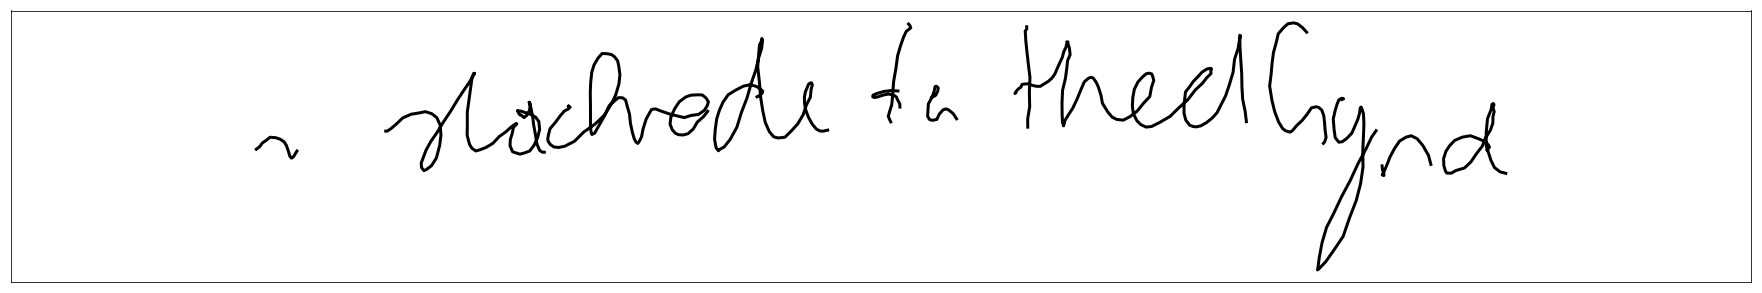

In [57]:
# test generation 60
s = generate_unconditionally(model,700, 20)
plot_stroke(s)

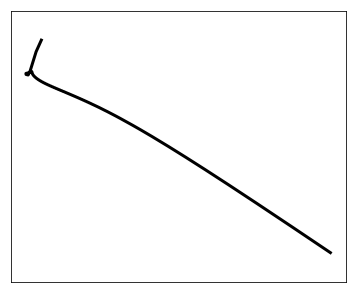

In [38]:
# test generation 60
g = greedy_generate(model)
g[650][0]=1
plot_stroke(g)

In [23]:
def control_generate(model, steps=700, random_seed=1, temp=.9):
    torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h1_init, c1_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    h2_init, c2_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h1_init = h1_init.cuda()
        c1_init = c1_init.cuda()
        h2_init = h2_init.cuda()
        c2_init = c2_init.cuda()
    x = Variable(zero_tensor)
    h1_init, c1_init = Variable(h1_init), Variable(c1_init)
    h2_init, c2_init = Variable(h2_init), Variable(c2_init)
    prev = (h1_init, c1_init)
    prev2 = (h2_init, c2_init)
    
    record = []
    # greedy but not the right generation
    for i in range(steps):        
        if np.random.random() < temp:
            end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2 = model(x, prev, prev2)
            prob_end = end.data[0][0][0]
            sample_end = np.round(prob_end)

            sample_index = np.argmax(weights.data[0][0].cpu().numpy())
            mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])

            out = np.array([sample_end, mu[0], mu[1]])
            record.append(out)
            x = torch.from_numpy(out).type(torch.FloatTensor)
            if cuda:
                x = x.cuda()
            x = Variable(x, requires_grad=False)
            x = x.view((1,1,3))
        
        else:
            end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, prev, prev2 = model(x, prev, prev2)
            prob_end = end.data[0][0][0]
            sample_end = np.random.binomial(1,prob_end)

            sample_index = np.random.choice(range(20),p = weights.data[0][0].cpu().numpy())
            mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])
            v1 = log_sigma_1.data[0][0][sample_index]**2
            v2 = log_sigma_2.data[0][0][sample_index]**2
            c = p.data[0][0][sample_index]*log_sigma_1.data[0][0][sample_index]*log_sigma_2.data[0][0][sample_index]
            cov = np.array([[v1,c],[c,v2]])
            sample_point = np.random.multivariate_normal(mu, cov)
            out = np.insert(sample_point,0,sample_end)
            record.append(out)
            x = torch.from_numpy(out).type(torch.FloatTensor)
            if cuda:
                x = x.cuda()
            x = Variable(x, requires_grad=False)
            x = x.view((1,1,3))
    return np.array(record)

In [ ]:
# test generation 30
s = generate_unconditionally(200,42)
plot_stroke(s)

In [ ]:
# test generation 30
g = greedy_generate()
g[650][0]=1
plot_stroke(g)


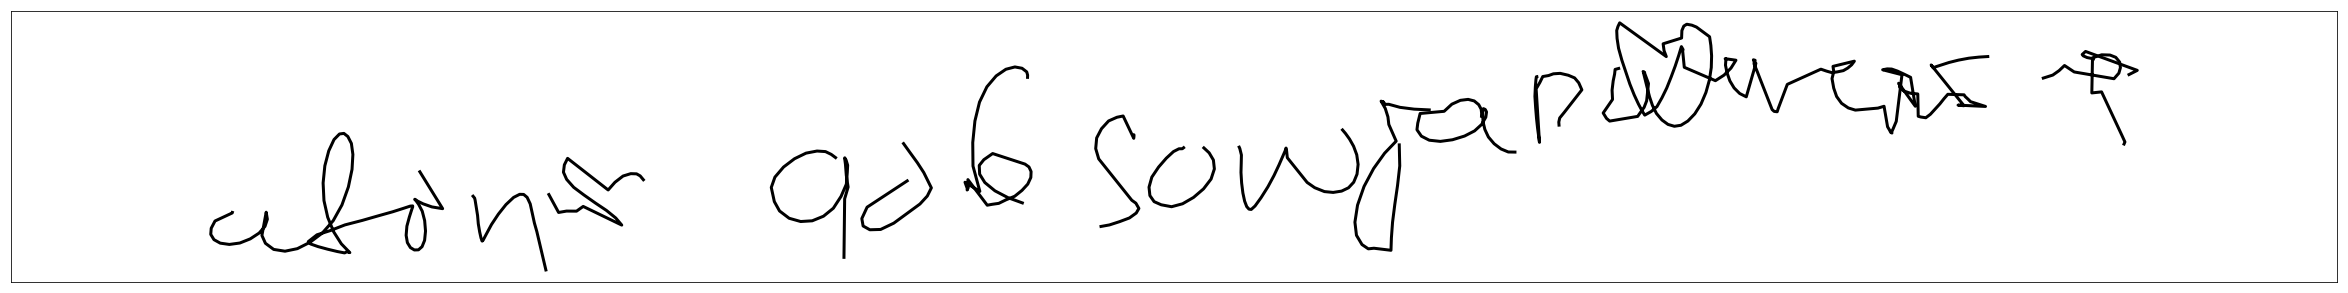

In [30]:
c = control_generate(model)
plot_stroke(c)

In [36]:
t_loss

[-28.086065303096063,
 -48.79650156882957,
 -58.93631822374132,
 -67.12821662959347,
 -71.9632894015842,
 -80.53014246509693,
 -85.78124413158275,
 -92.57717687536169,
 -91.92164607747395,
 -88.20615270996093,
 -86.57542263002749,
 -103.32721968135127,
 -109.43545268192997,
 -104.17896885850695,
 -115.60757298900462,
 -121.60645355902778,
 -126.32176795789931,
 -130.05347511574075,
 -135.97123421223958,
 -140.9712773256655,
 -145.67745540364584,
 -140.22001325593172,
 -149.67298097511573,
 -155.2889003725405,
 -159.6627472330729,
 -163.0801248372396,
 -164.9523870985243,
 -169.5118175817419,
 -160.19797047706888,
 -166.85497097439236,
 -177.18538190827547,
 -179.65547271050346,
 -182.49955750868057,
 -172.69286366102432,
 -151.1087958351418,
 -182.82373658130788,
 -188.07221831597224,
 -191.0622146629051,
 -194.32898840784142,
 -161.4028803394459]

In [42]:
np.argmin(np.array([s/100 for s in v_loss]))

15

In [50]:
state2 = torch.load('epoch_40_d.pt')
model.load_state_dict(state2['model'])

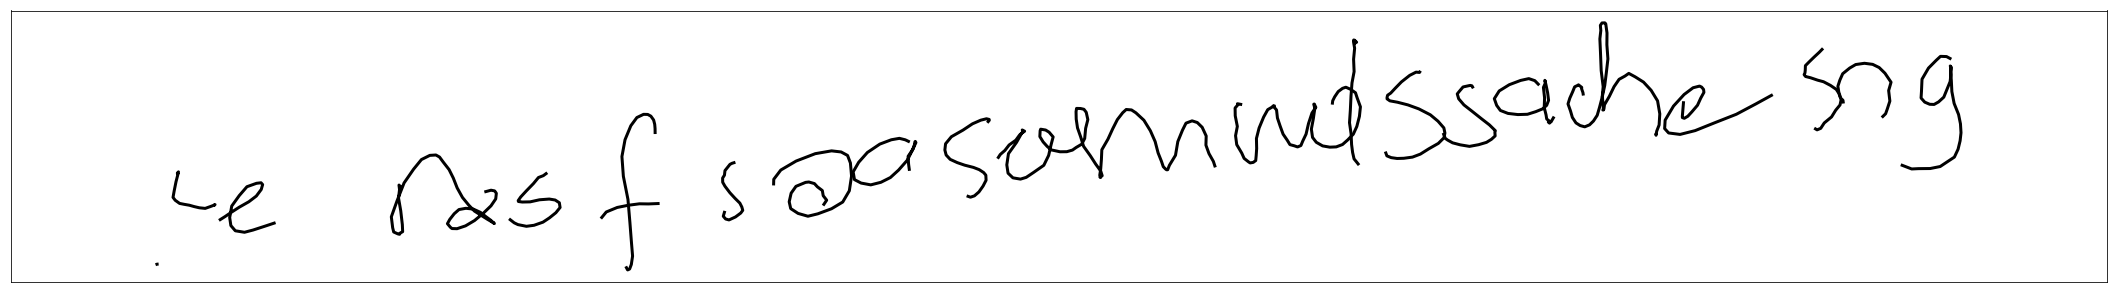

In [53]:
s = generate_unconditionally(model,700,4)
plot_stroke(s)